# Сравнение метеопараметров, полученных с реанализа CFS2 и станций Ура-Губа и Полярный

Метеостанции:
* Ура-Губа 22018 69° 17' с.ш., 32° 48' в.д.; 27 м -- (69.283 с.ш.; 32.80 в.д.)
* Полярный 22019 69° 12' с.ш., 33° 28.823999999999998' в.д.; 13 м -- (69.20 с.ш.; 33.48 в.д.)

In [1]:
import os
import numpy as np
import pandas as pd

from meteotik.reanalysis import CFS2Processor
from meteotik.meteo import Rp5Station
import datetime

from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
rean_processor = CFS2Processor('D:/ura-guba/cfs2', u10_name = 'u10', v10_name = 'v10')

# Посмотрим какие есть переменные в файлах
rean_processor.print_variables()

Variables in netcdf file ['time', 'lon', 'lat', 'height', 'u10', 'v10']


## Обработка реанализа
### Временной ряд для метеостанции Ура-Губа

На картинке показан пространственный охват сетки реанализа

"Lower left" corner: latitude - -89.84351351786847, longitude - 0.0
"Upper right" corner: latitude - 89.84351351786847, longitude - 359.79545454545456
The scope by latitude - 179.68702703573695
The scope by longitude - 359.79545454545456 



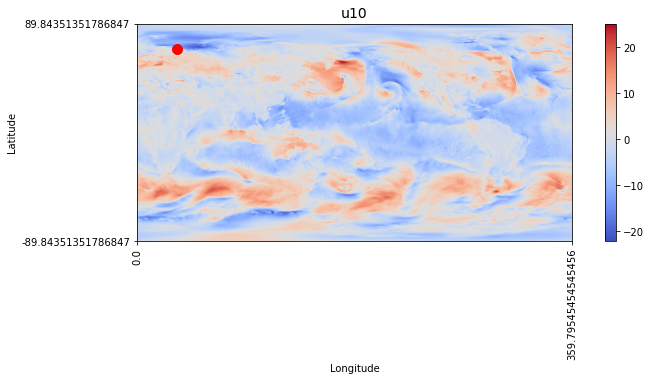

In [3]:
rean_processor.show_spatial_coverage()
rean_processor.field_visualisation(variable = 'u10',
                                   coordinates = {'lat': 69.283, 'lon': 32.80})

Формирование временного ряда с часовой дискретностью для метеостанции (изначальные значения 6-часовой дискретности интерполируются на новую сетку временного ряда).

Processing... cfs2u_wind_201701.nc
Processing... cfs2u_wind_201702.nc
Processing... cfs2u_wind_201703.nc
Processing... cfs2u_wind_201704.nc
Processing... cfs2u_wind_201705.nc
Processing... cfs2u_wind_201706.nc
Processing... cfs2u_wind_201707.nc
Processing... cfs2u_wind_201708.nc
Processing... cfs2u_wind_201709.nc
Processing... cfs2u_wind_201710.nc
Processing... cfs2u_wind_201711.nc
Processing... cfs2u_wind_201802.nc
Processing... cfs2u_wind_201803.nc


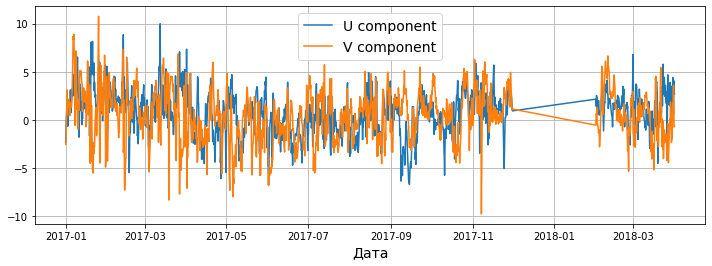

In [4]:
ura_data = rean_processor.prepare_time_series(coordinates = {'lat': 69.283, 'lon': 32.80},
                                              change_time_step = True,
                                              new_time_step='1H')

# Переименуем колонки
ura_data = ura_data.rename(columns={"U_reanalysis": "U компонента (CFS2)",
                                    "V_reanalysis": "V компонента (CFS2)", 
                                    "Velocity_reanalysis": "Скорость ветра (CFS2)"})

plt.plot(ura_data['Date'], ura_data['U компонента (CFS2)'], label = 'U component')
plt.plot(ura_data['Date'], ura_data['V компонента (CFS2)'], label = 'V component')
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('Дата', fontsize=14)
plt.show()

### Временной ряд для метеостанции Полярный

Processing... cfs2u_wind_201701.nc
Processing... cfs2u_wind_201702.nc
Processing... cfs2u_wind_201703.nc
Processing... cfs2u_wind_201704.nc
Processing... cfs2u_wind_201705.nc
Processing... cfs2u_wind_201706.nc
Processing... cfs2u_wind_201707.nc
Processing... cfs2u_wind_201708.nc
Processing... cfs2u_wind_201709.nc
Processing... cfs2u_wind_201710.nc
Processing... cfs2u_wind_201711.nc
Processing... cfs2u_wind_201802.nc
Processing... cfs2u_wind_201803.nc


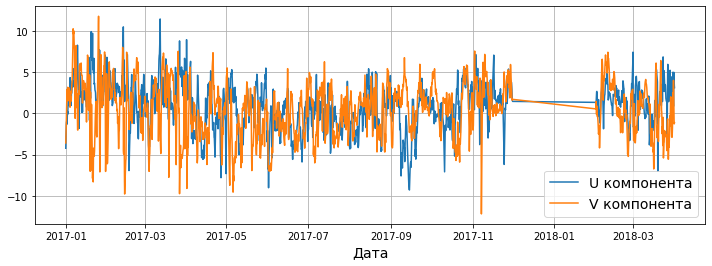

In [5]:
pol_data = rean_processor.prepare_time_series(coordinates = {'lat': 69.20, 'lon': 33.48},
                                              change_time_step = True,
                                              new_time_step='1H')
# Переименуем колонки
pol_data = pol_data.rename(columns={"U_reanalysis": "U компонента (CFS2)",
                                    "V_reanalysis": "V компонента (CFS2)", 
                                    "Velocity_reanalysis": "Скорость ветра (CFS2)"})

plt.plot(pol_data['Date'], pol_data['U компонента (CFS2)'], label = 'U компонента')
plt.plot(pol_data['Date'], pol_data['V компонента (CFS2)'], label = 'V компонента')
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('Дата', fontsize=14)
plt.show()

Как видно из выводимых сообщений, в папке отсутсвуют данные за декабрь 2017го и январь 2018го. Данный пропуск заметен и на графике.

## Метеостанции
### Метеостанция Ура-Губа

In [6]:
meteo_ura = pd.read_excel('D:/ura-guba/meteo/Ura_station.xls', comment = '#')
meteo_ura = meteo_ura[['Местное время в Ура-Губе', 'DD', 'Ff']]
meteo_ura = meteo_ura.rename(columns={'Местное время в Ура-Губе': 'Date',
                                      'DD': 'Направление ветра (метеостанция)',
                                      'Ff': 'Скорость ветра (метеостанция)'})
meteo_ura['Date'] = pd.to_datetime(meteo_ura['Date'], format = '%d.%m.%Y %H:%M')
meteo_ura.dropna(inplace=True)

# Конвертация словесного описания направления ветра в румбы
station_processor = Rp5Station(meteo_ura)
codes = station_processor.convert_wind_direction('Направление ветра (метеостанция)')
meteo_ura['Направление ветра (метеостанция)'] = codes

# Расчет U и V компонент из скорости и направления
station_processor = Rp5Station(meteo_ura)
u_arr, v_arr = station_processor.calculate_uv(vel_col='Скорость ветра (метеостанция)',
                                              direction_col='Направление ветра (метеостанция)')

meteo_ura['U компонента (метеостанция)'] = u_arr
meteo_ura['V компонента (метеостанция)'] = v_arr

# Так как время местное, переведем его к зоне Гринвича - то есть сместим на 3 часа назад
meteo_ura['Date'] = station_processor.time_shift(dataframe = meteo_ura, 
                                                 date_col = 'Date', 
                                                 shift = 3, 
                                                 add = False)
meteo_ura.head(3)

,Date,Направление ветра (метеостанция),Скорость ветра (метеостанция),U компонента (метеостанция),V компонента (метеостанция)
0,2019-12-31 18:00:00,225.0,7,4.949747,4.949747e+00
1,2019-12-31 12:00:00,270.0,6,6.000000,1.102182e-15
2,2019-12-31 06:00:00,270.0,4,4.000000,7.347881e-16


### Метеостанция Полярный

In [8]:
meteo_pol = pd.read_excel('D:/ura-guba/meteo/Pol_station.xls', comment = '#')
meteo_pol = meteo_pol[['Местное время в Полярном', 'DD', 'Ff']]
meteo_pol = meteo_pol.rename(columns={'Местное время в Полярном': 'Date',
                                      'DD': 'Направление ветра (метеостанция)',
                                      'Ff': 'Скорость ветра (метеостанция)'})
meteo_pol['Date'] = pd.to_datetime(meteo_pol['Date'], format = '%d.%m.%Y %H:%M')
meteo_pol.dropna(inplace=True)

# Конвертация словесного описания направления ветра в румбы
station_processor = Rp5Station(meteo_pol)
codes = station_processor.convert_wind_direction('Направление ветра (метеостанция)')
meteo_pol['Направление ветра (метеостанция)'] = codes

# Расчет U и V компонент из скорости и направления
station_processor = Rp5Station(meteo_pol)
u_arr, v_arr = station_processor.calculate_uv(vel_col='Скорость ветра (метеостанция)',
                                              direction_col='Направление ветра (метеостанция)')

meteo_pol['U компонента (метеостанция)'] = u_arr
meteo_pol['V компонента (метеостанция)'] = v_arr

# Так как время местное, переведем его к зоне Гринвича - то есть сместим на 3 часа назад
meteo_pol['Date'] = station_processor.time_shift(dataframe = meteo_pol, 
                                                 date_col = 'Date', 
                                                 shift = 3, 
                                                 add = False)
meteo_pol.head(3)

,Date,Направление ветра (метеостанция),Скорость ветра (метеостанция),U компонента (метеостанция),V компонента (метеостанция)
0,2019-12-31 18:00:00,180.0,5.0,-6.123234e-16,5.000000e+00
1,2019-12-31 12:00:00,270.0,6.0,6.000000e+00,1.102182e-15
2,2019-12-31 06:00:00,315.0,7.0,4.949747e+00,-4.949747e+00


## Сравнение
### Метеостанция Ура-Губа

In [9]:
from meteotik.analysis import equal_mapping
from meteotik.analysis import print_statistics

# Приводим датафреймы к единому виду 
meteo_df, rean_df = equal_mapping(dataframe_left=meteo_ura, 
                                  dataframe_right=ura_data,
                                  merge_column='Date')

# Вывод статистик 
print_statistics(dataframe_left = meteo_df,
                 dataframe_right = rean_df,
                 columns_for_compare = {'U компонента (метеостанция)':'U компонента (CFS2)', 
                                        'V компонента (метеостанция)':'V компонента (CFS2)',
                                        'Скорость ветра (метеостанция)':'Скорость ветра (CFS2)'})

Bias for U компонента (метеостанция) vs U компонента (CFS2): 0.01
MAE for U компонента (метеостанция) vs U компонента (CFS2): 1.30
Pearson correlation coefficient for U компонента (метеостанция) vs U компонента (CFS2): 0.79


Bias for V компонента (метеостанция) vs V компонента (CFS2): -0.35
MAE for V компонента (метеостанция) vs V компонента (CFS2): 1.46
Pearson correlation coefficient for V компонента (метеостанция) vs V компонента (CFS2): 0.79


Bias for Скорость ветра (метеостанция) vs Скорость ветра (CFS2): -0.56
MAE for Скорость ветра (метеостанция) vs Скорость ветра (CFS2): 1.30
Pearson correlation coefficient for Скорость ветра (метеостанция) vs Скорость ветра (CFS2): 0.68




С помощью праметров x_min и x_max можно задать границы интервала, для которого будут нарисованы графики (так удобнее сравнивать, так как при слишком мелком масштабе может быть трудно разглядеть совпадающие паттерны).

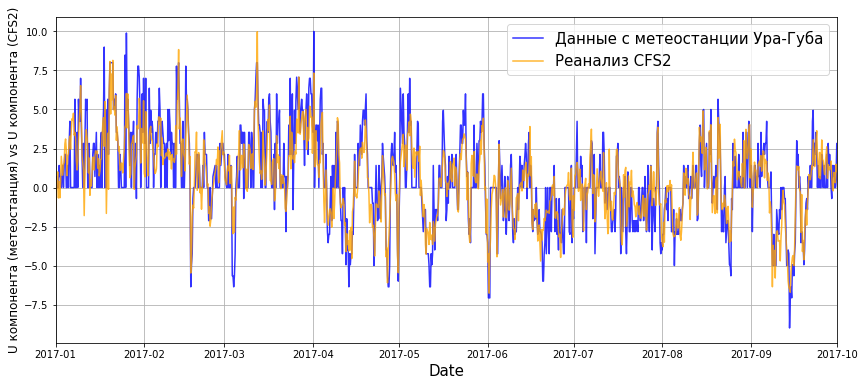

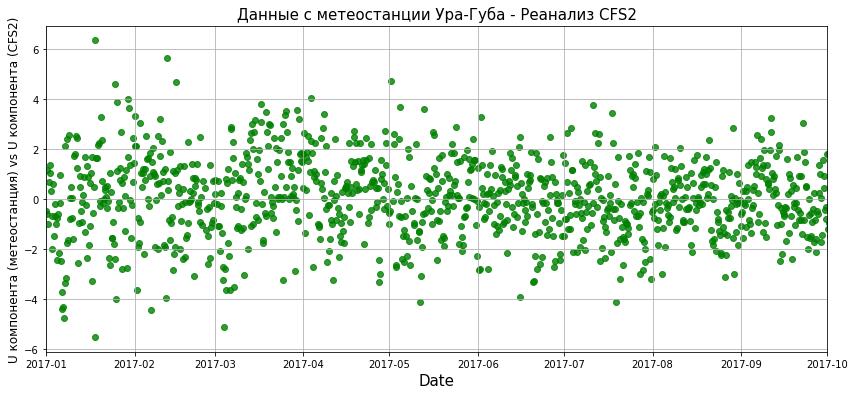

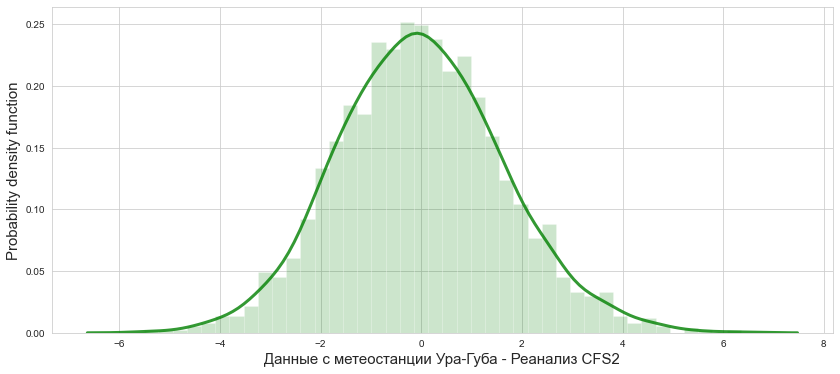

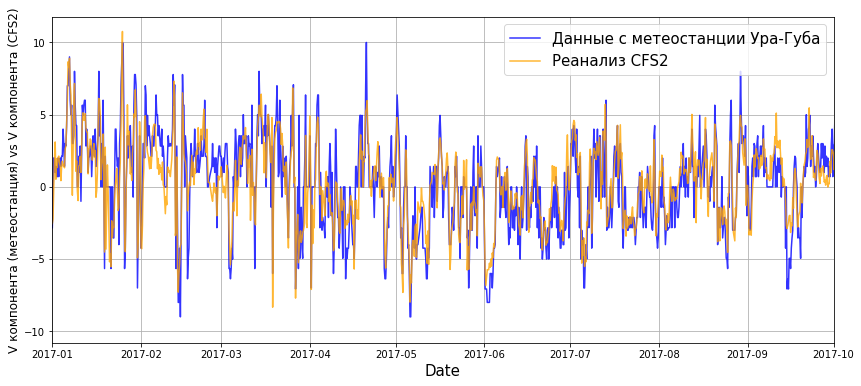

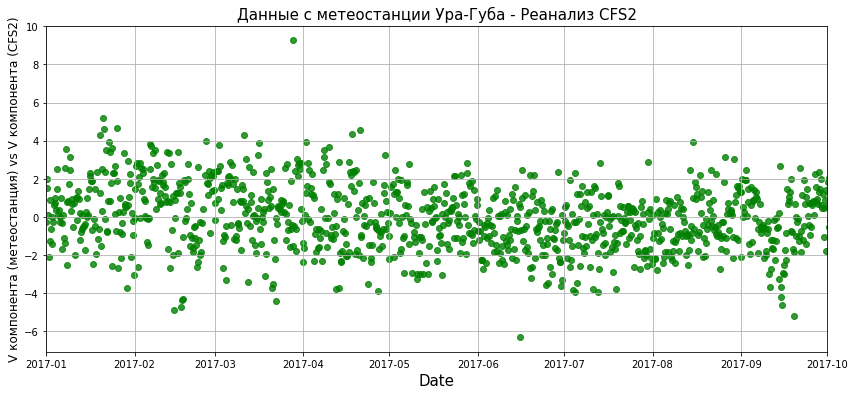

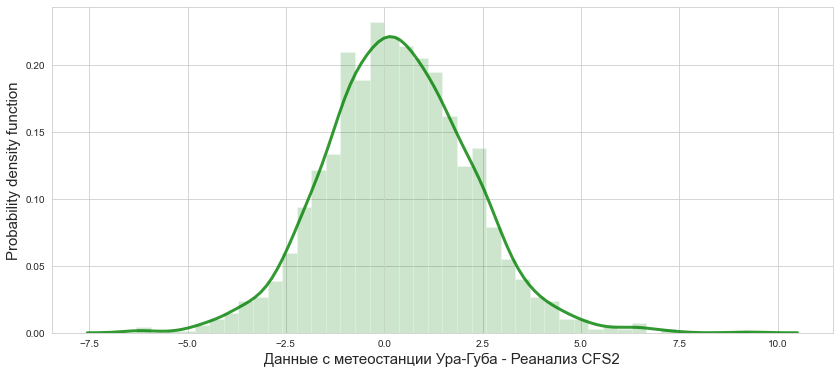

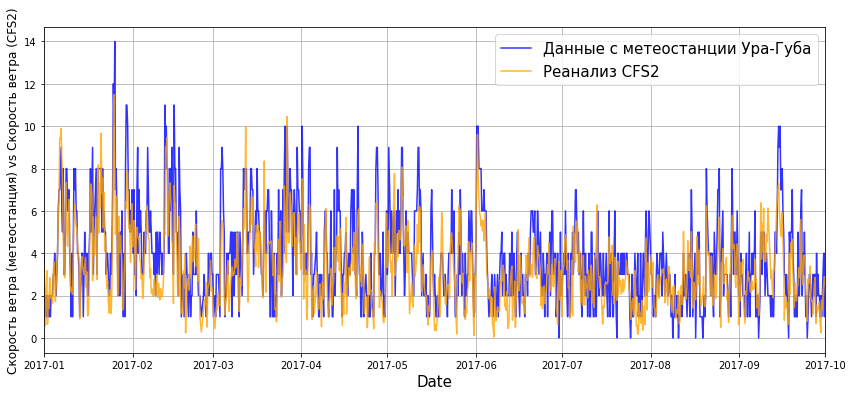

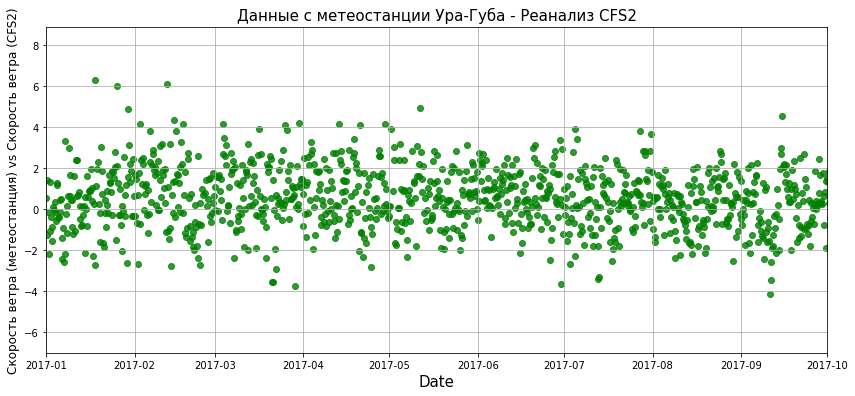

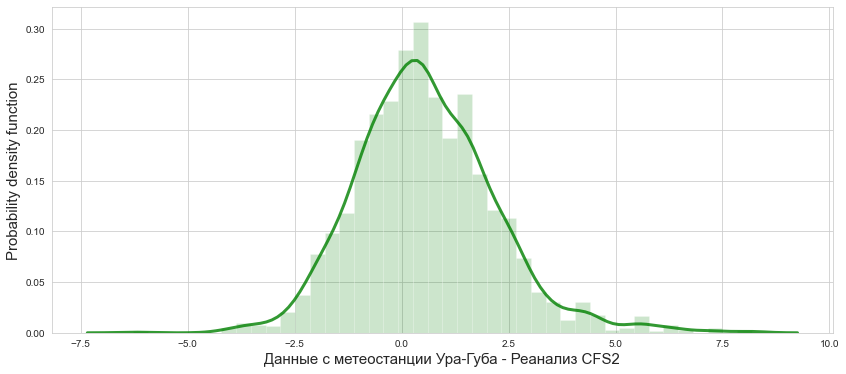

In [10]:
from meteotik.analysis import make_visual_comparison
rcParams['figure.figsize'] = 14, 6
                                    
make_visual_comparison(dataframe_left = meteo_df,
                       dataframe_right = rean_df,
                       columns_for_compare = {'U компонента (метеостанция)':'U компонента (CFS2)', 
                                              'V компонента (метеостанция)':'V компонента (CFS2)',
                                              'Скорость ветра (метеостанция)':'Скорость ветра (CFS2)'},
                       dataframe_labels = ['Данные с метеостанции Ура-Губа', 'Реанализ CFS2'],
                       x_min = "2017-1-1", x_max = "2017-10-1")

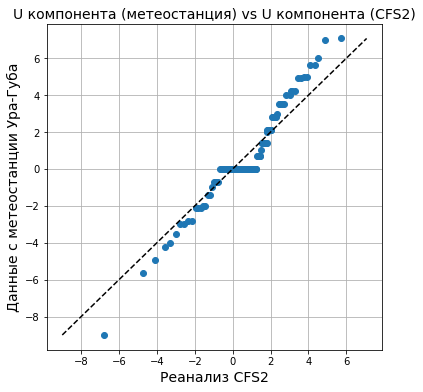

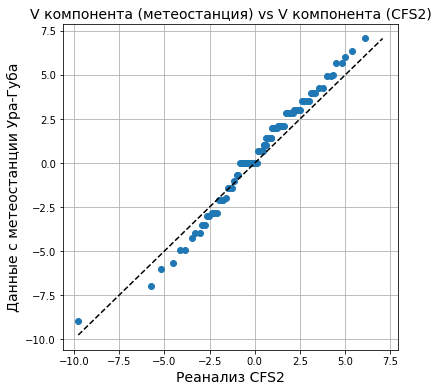

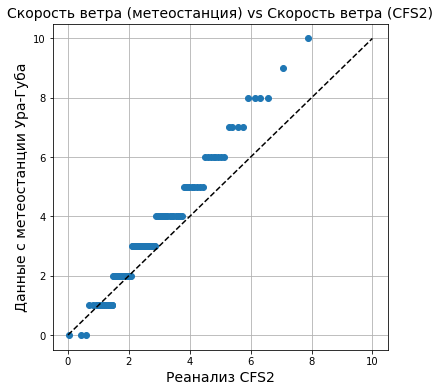

In [11]:
from meteotik.analysis import qq_comparison
rcParams['figure.figsize'] = 6, 6

qq_comparison(dataframe_left = meteo_df,
              dataframe_right = rean_df,
              columns_for_compare = {'U компонента (метеостанция)':'U компонента (CFS2)', 
                                     'V компонента (метеостанция)':'V компонента (CFS2)',
                                     'Скорость ветра (метеостанция)':'Скорость ветра (CFS2)'},
              dataframe_labels = ['Данные с метеостанции Ура-Губа', 'Реанализ CFS2'])

In [12]:
from meteotik.analysis import make_report

df = make_report(dataframe_left = meteo_df,
                 dataframe_right = rean_df,
                 columns_for_compare = {'U компонента (метеостанция)':'U компонента (CFS2)', 
                                        'V компонента (метеостанция)':'V компонента (CFS2)',
                                        'Скорость ветра (метеостанция)':'Скорость ветра (CFS2)'},
                 check_peaks = True)

df

,Variables,Bias,MAE,Correlation
0,U компонента (метеостанция) vs U компонента (C...,0.005042,1.297971,0.785078
1,(Peak) U компонента (метеостанция) vs U компон...,-1.552644,1.708070,0.557744
2,V компонента (метеостанция) vs V компонента (C...,-0.349164,1.457044,0.786551
3,(Peak) V компонента (метеостанция) vs V компон...,-1.734171,2.003111,0.494877
4,Скорость ветра (метеостанция) vs Скорость ветр...,-0.563422,1.304000,0.675973
5,(Peak) Скорость ветра (метеостанция) vs Скорос...,-2.295739,2.463374,0.431992


### Метеостанция Полярный

In [13]:
# Приводим датафреймы к единому виду 
meteo_df, rean_df = equal_mapping(dataframe_left=meteo_pol, 
                                  dataframe_right=pol_data,
                                  merge_column='Date')

# Вывод статистик 
print_statistics(dataframe_left = meteo_df,
                 dataframe_right = rean_df,
                 columns_for_compare = {'U компонента (метеостанция)':'U компонента (CFS2)', 
                                        'V компонента (метеостанция)':'V компонента (CFS2)',
                                        'Скорость ветра (метеостанция)':'Скорость ветра (CFS2)'})

Bias for U компонента (метеостанция) vs U компонента (CFS2): -0.05
MAE for U компонента (метеостанция) vs U компонента (CFS2): 1.60
Pearson correlation coefficient for U компонента (метеостанция) vs U компонента (CFS2): 0.79


Bias for V компонента (метеостанция) vs V компонента (CFS2): -0.28
MAE for V компонента (метеостанция) vs V компонента (CFS2): 1.59
Pearson correlation coefficient for V компонента (метеостанция) vs V компонента (CFS2): 0.86


Bias for Скорость ветра (метеостанция) vs Скорость ветра (CFS2): -1.05
MAE for Скорость ветра (метеостанция) vs Скорость ветра (CFS2): 1.59
Pearson correlation coefficient for Скорость ветра (метеостанция) vs Скорость ветра (CFS2): 0.73




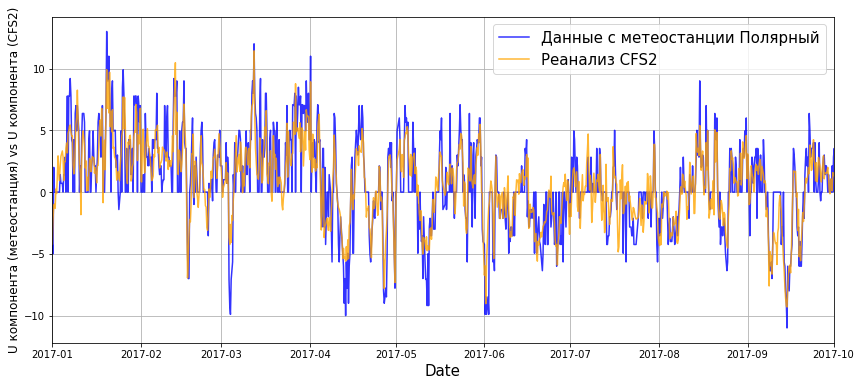

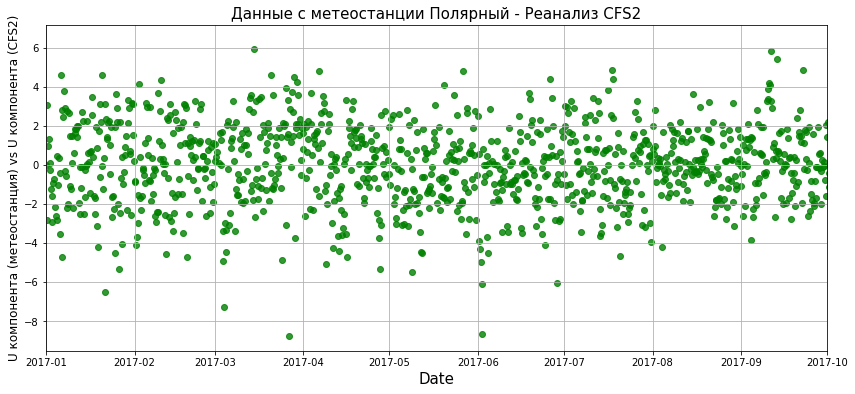

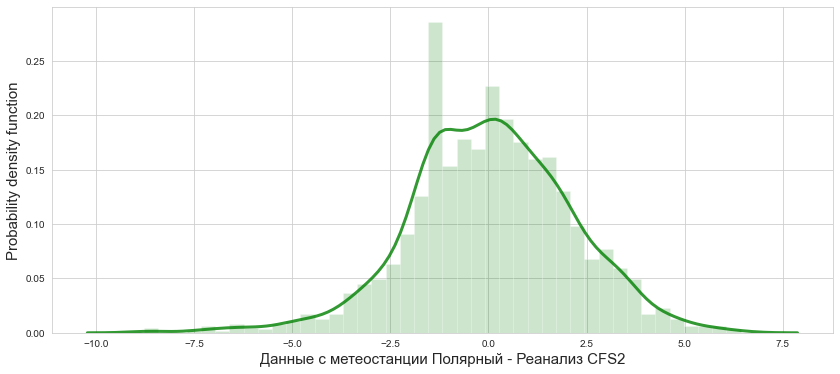

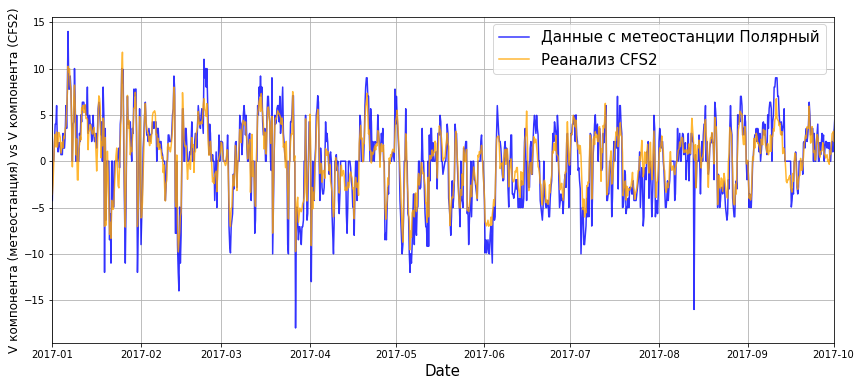

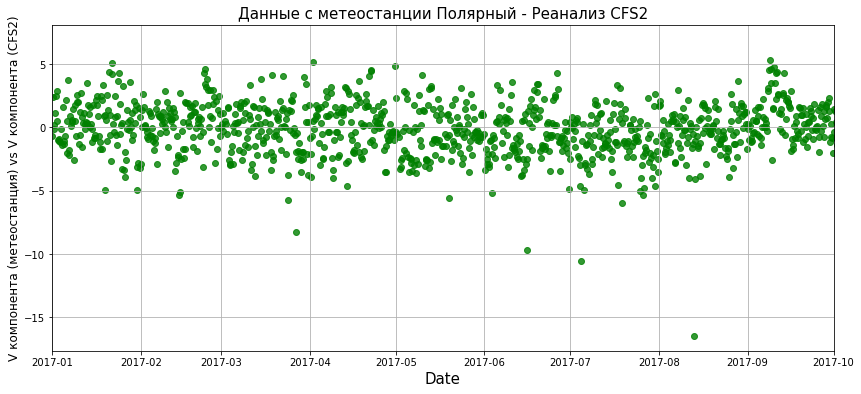

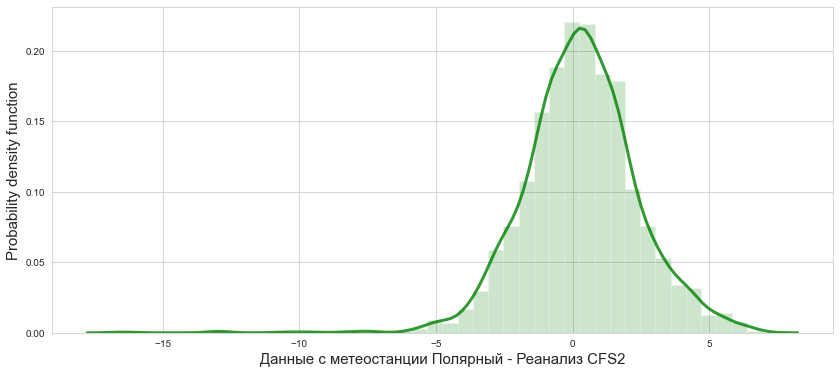

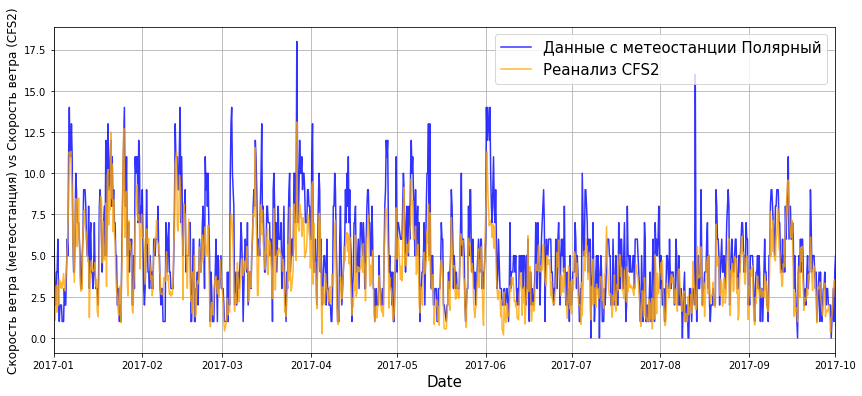

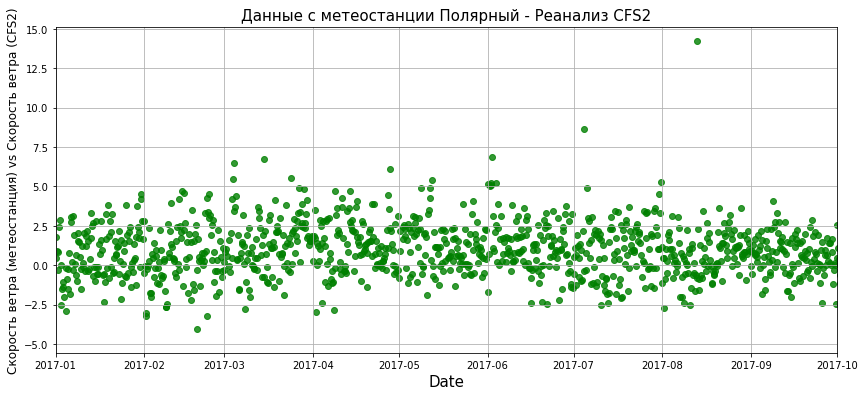

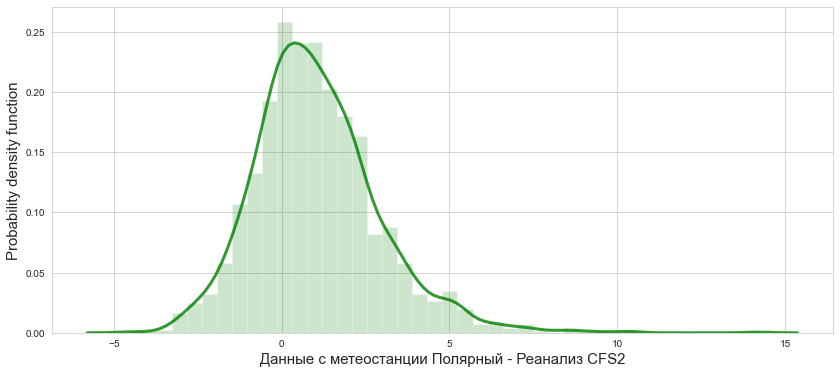

In [14]:
from meteotik.analysis import make_visual_comparison
rcParams['figure.figsize'] = 14, 6

make_visual_comparison(dataframe_left = meteo_df,
                       dataframe_right = rean_df,
                       columns_for_compare = {'U компонента (метеостанция)':'U компонента (CFS2)', 
                                              'V компонента (метеостанция)':'V компонента (CFS2)',
                                              'Скорость ветра (метеостанция)':'Скорость ветра (CFS2)'},
                       dataframe_labels = ['Данные с метеостанции Полярный', 'Реанализ CFS2'],
                       x_min = "2017-1-1", x_max = "2017-10-1")

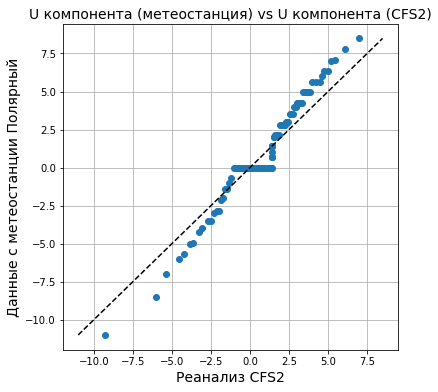

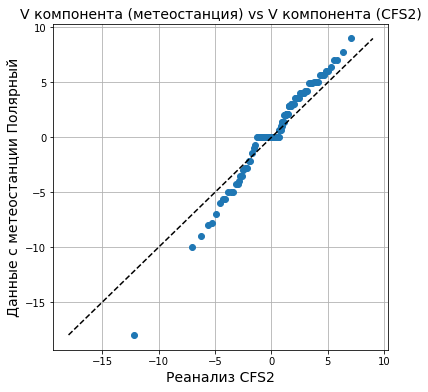

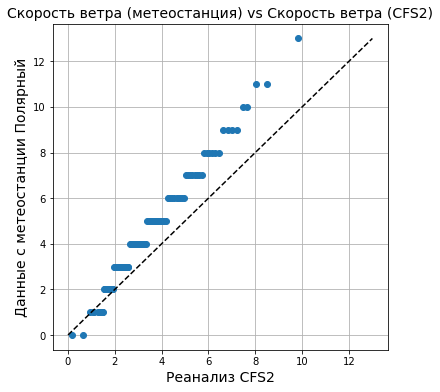

In [15]:
from meteotik.analysis import qq_comparison
rcParams['figure.figsize'] = 6, 6

qq_comparison(dataframe_left = meteo_df,
              dataframe_right = rean_df,
              columns_for_compare = {'U компонента (метеостанция)':'U компонента (CFS2)', 
                                     'V компонента (метеостанция)':'V компонента (CFS2)',
                                     'Скорость ветра (метеостанция)':'Скорость ветра (CFS2)'},
              dataframe_labels = ['Данные с метеостанции Полярный', 'Реанализ CFS2'])

In [16]:
from meteotik.analysis import make_report

df = make_report(dataframe_left = meteo_df,
                 dataframe_right = rean_df,
                 columns_for_compare = {'U компонента (метеостанция)':'U компонента (CFS2)', 
                                        'V компонента (метеостанция)':'V компонента (CFS2)',
                                        'Скорость ветра (метеостанция)':'Скорость ветра (CFS2)'},
                 check_peaks = True)

df

,Variables,Bias,MAE,Correlation
0,U компонента (метеостанция) vs U компонента (C...,-0.049307,1.600979,0.794099
1,(Peak) U компонента (метеостанция) vs U компон...,-1.886063,2.071782,0.582605
2,V компонента (метеостанция) vs V компонента (C...,-0.282109,1.593928,0.858707
3,(Peak) V компонента (метеостанция) vs V компон...,-1.860320,2.121854,0.445739
4,Скорость ветра (метеостанция) vs Скорость ветр...,-1.046959,1.586316,0.729565
5,(Peak) Скорость ветра (метеостанция) vs Скорос...,-2.850063,2.917973,0.519601
